In [1]:
import sys
from pathlib import Path

path_root = Path( '/project_ghent/HADSP/reservoirpy/')
sys.path.append(str(path_root))
path_root = Path( '/project_ghent/HADSP/hadsp/')
sys.path.append(str(path_root))

In [2]:
import numpy as np
from scipy import sparse
from tqdm import tqdm

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from importlib import reload

# Utility functions
from reservoir.utility import show_matrice

# SEED
SEED = 49387

# Reservoir functions

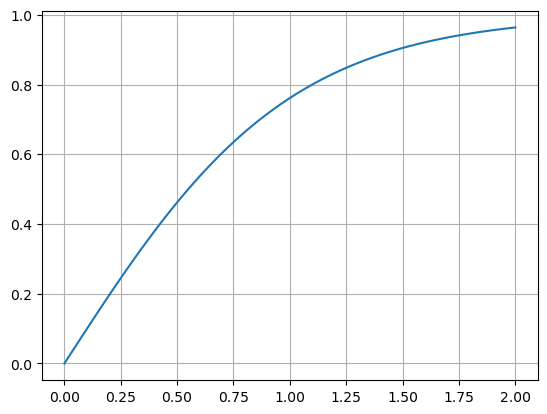

In [4]:
from reservoir.reservoir import update_reservoir, ridge_regression, train, run
from reservoir.activation_functions import tanh, heaviside, sigmoid

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 2, 100), activation_function(np.linspace(0, 2, 100)))
plt.grid()

# Datasets

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Classification: 
https://arxiv.org/abs/1803.07870

https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing

Multivariate:
https://www.timeseriesclassification.com/dataset.php

## Mackey-Glass

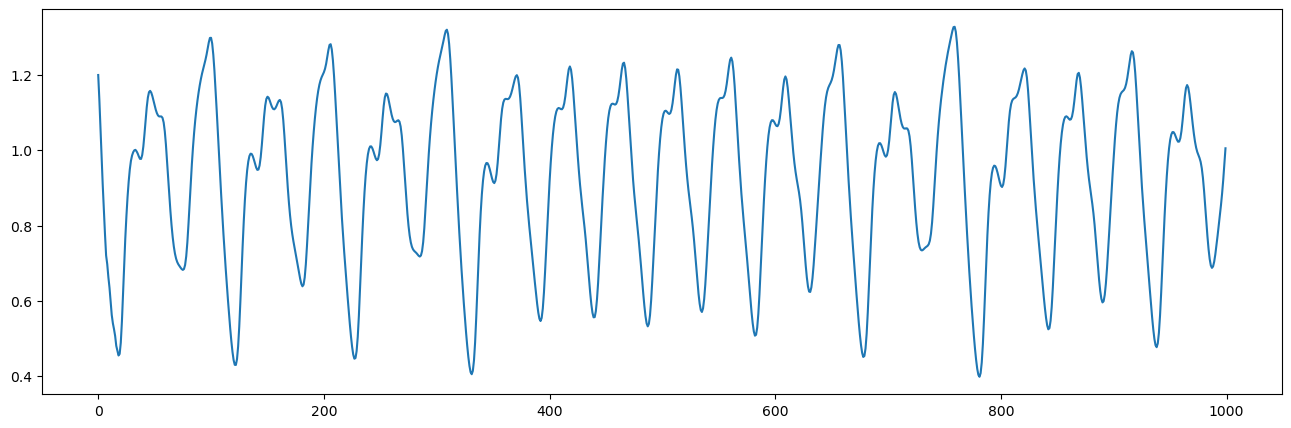

In [5]:
from reservoirpy.datasets import mackey_glass

timesteps = 10000
mg_inputs = mackey_glass(timesteps, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1, seed=None)

# Define the time step of your Mackey-Glass system
dt = 0.00001

# Compute the equivalent sampling rate
sampling_rate = 1 / dt

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(range(1000), mg_inputs[:1000])
plt.show()

## Japanese voyels

In [6]:
from reservoirpy.datasets import japanese_vowels

X_train, Y_train, X_test, Y_test = japanese_vowels()

In [7]:
X_pretrain = np.concatenate(X_train, axis=0)
X_pretrain.shape
filtered_data = X_pretrain.T

## InsectWingbeat

## MELD

https://github.com/declare-lab/MELD


## Free Spoken Digits Dataset

In [9]:
from datasets.load_datasets import load_FSDD_dataset

data_dir = 'datasets/fsdd/free-spoken-digit-dataset-master/recordings'  # Path to the extracted dataset
sampling_rate, X_train, X_test, Y_train, Y_test = load_FSDD_dataset(data_dir, seed=SEED)
# Check the shapes of the datasets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of audio files: 3000


100%|██████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 11850.64it/s]

Mean sampling rate: 8000.0
X_train shape: (1500,)
Y_train shape: (1500, 10)
X_test shape: (1500,)
Y_test shape: (1500, 10)


# New inputs creation with band filters

Spectrograms_vs_Cochleagrams : 
* https://www.researchgate.net/publication/340510607_Speech_recognition_using_very_deep_neural_networks_Spectrograms_vs_Cochleagrams

## Pretrain dataset

In [10]:
#take a long time (15min with half the samples, instant with 20 which is enought for pretraining)
X_pretrain = np.concatenate(X_train[:20], axis=0)
print(X_pretrain.shape)

(67926, 1)


## Spectral density and peak selection

In [11]:
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies

filtered_peak_freqs = extract_peak_frequencies(X_pretrain.flatten(), sampling_rate, nperseg=1024, visualize=False)

## Applying normal band pass filter on data

In [12]:
X_pretrain_band, X_train_band, X_test_band = generate_multivariate_dataset(filtered_peak_freqs, X_pretrain, X_train, X_test, sampling_rate, nb_jobs=-1, visualize=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header,

## Standardizing the amplitudes

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

# pretrain
filtered_data = scaler.fit_transform(X_pretrain_band)

In [14]:
# train
X_train_band = [np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in x]) for x in X_train_band]

In [15]:
# test
X_test_band = [np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in x]) for x in X_test_band]

In [16]:
X_train_band[0].shape

(105, 2859)

# Generating reservoirs

## Plot  pretrain dataset

In [17]:
# Min window size to get all the dynamics ? 
min_window_size = sampling_rate/filtered_peak_freqs[-1]

min_window_size

2.015748031496063

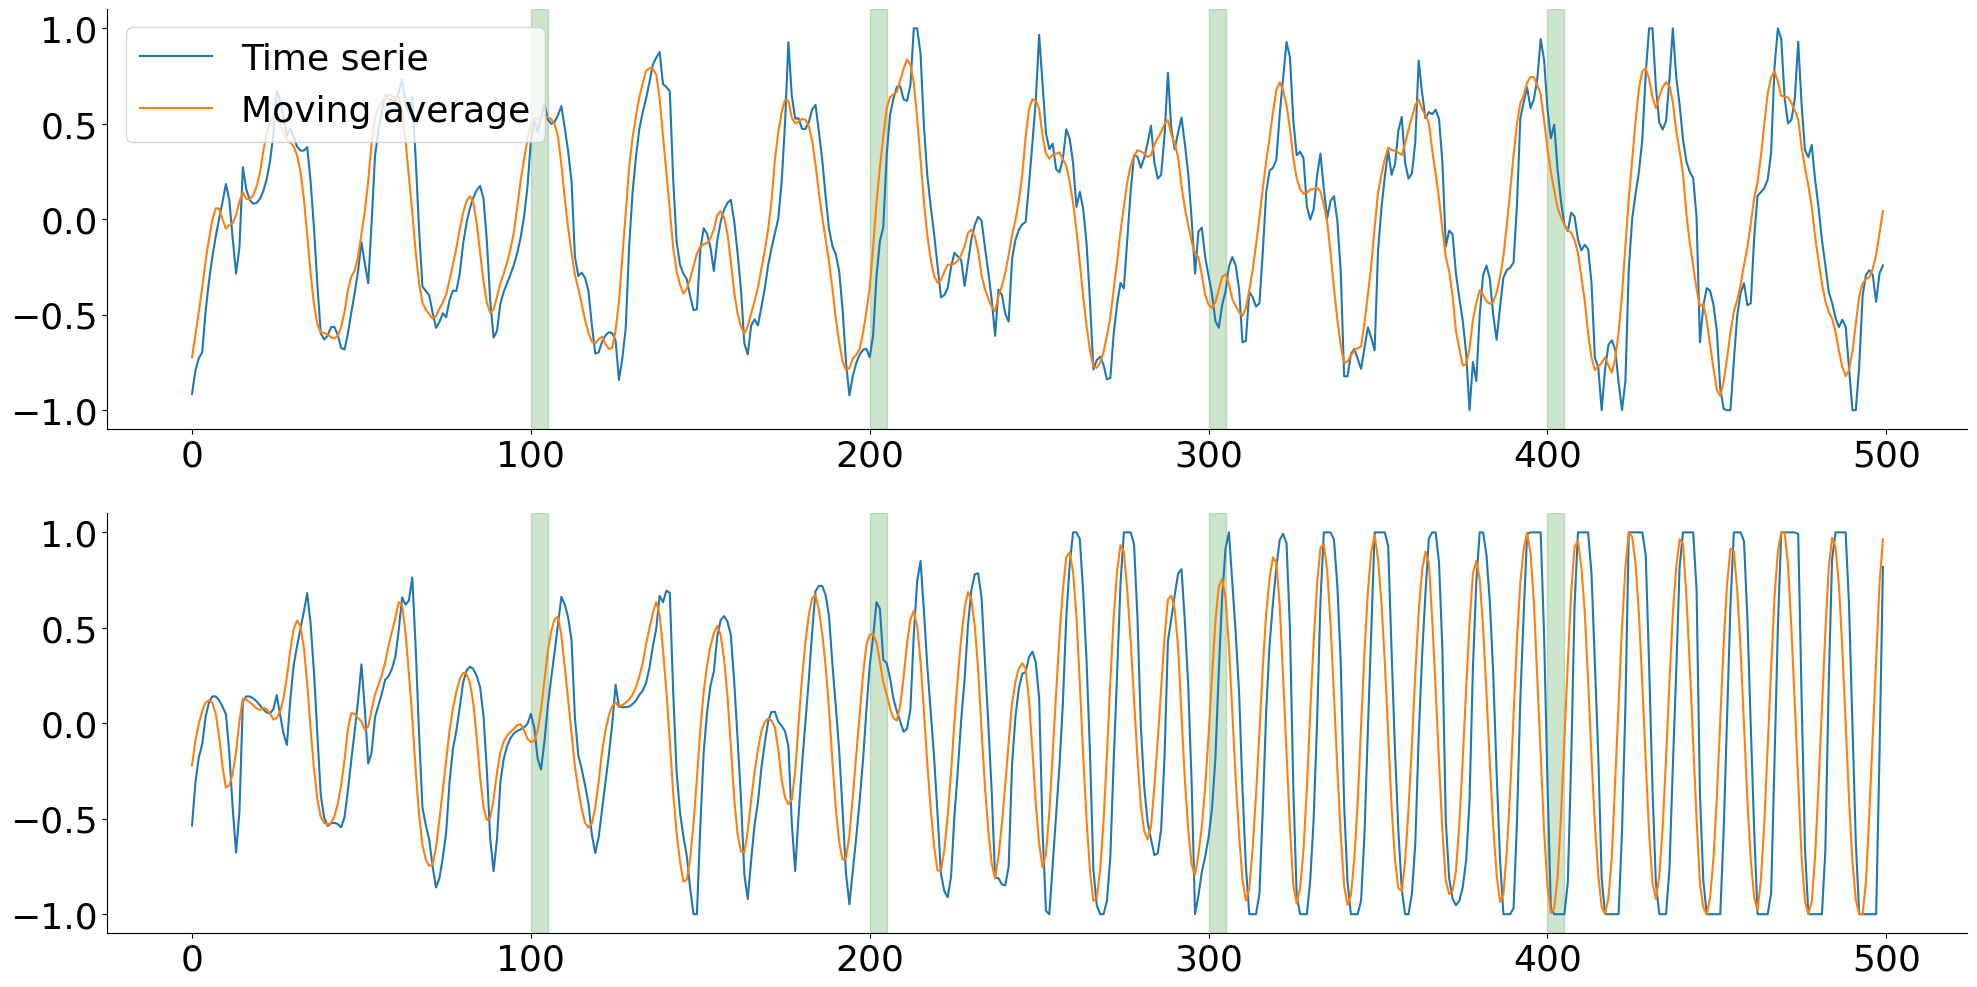

In [18]:
#Compute the moving average 
window_size = 5
weights = np.repeat(1.0, window_size)/window_size
ma = np.array([np.convolve(d, weights, 'valid') for d in (filtered_data)])

#CPlot the two for different frequencies
NB_1 = 3
fig, ax = plt.subplots(2, 1, figsize=(24,12))
ax[0].plot(range(500), filtered_data[NB_1, 1000:1500], label='Time serie')
ax[0].plot(range(500), ma[NB_1, 1000:1500], label='Moving average')
NB_2 = 10
ax[0].legend(fontsize=26)
ax[1].plot(range(500), filtered_data[NB_2, 1000:1500], label='Time serie')
ax[1].plot(range(500), ma[NB_2, 1000:1500], label='Moving average')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', labelsize=26)
ax[1].tick_params(axis='both', labelsize=26)


# draw vertical lines to represent the window for some points
for x in range(100, 500, 100):
    ax[0].axvspan(x, x+window_size, color='g', alpha=0.2)
for x in range(100, 500, 100):
    ax[1].axvspan(x, x+window_size, color='g', alpha=0.2)

plt.show()

## Construct matrices

### Shared parameters

In [19]:
import math 

# We want the size of the reservoir to be at least 200
K = math.ceil(200 / filtered_peak_freqs.shape[0])
n = filtered_peak_freqs.shape[0] * K
n

210

In [20]:
INCREMENT = 5
VALUE = 0.05
target_rate = 0.7
growth_parameter = 0.3

bias_scaling = 1
input_scaling = 0.1
leaky_rate = 1

In [21]:
import reservoir.reservoir
from reservoir.reservoir import update_reservoir
from reservoir.reservoir import init_matrices
from connexion_generation.utility import compute_synaptic_change
from connexion_generation.bounded_adsp import bounded_adsp

class TwoDimArrayWrapper:
    def __init__(self, input_data):
        if input_data.ndim != 2:
            raise ValueError("Expected a 2D array.")
        self.input_data = input_data
        self.shape = input_data.shape
        self.size = input_data.shape[1]
        self.flat_data = input_data.flatten()

    def __getitem__(self, key):
        # Handle single element access
        return self.input_data[:, key]

def run_HADSP_algorithm(W, Win, bias, input_data, visualize=False):
    # last_state
    state = np.random.uniform(0, 1, n)
    state_history = []
    
    total_add = 0
    total_prun = 0
    add = []
    prun = []
    step=0

    for i in range(INCREMENT*5):
        state = update_reservoir(W, Win, input_data[i], state, leaky_rate, bias, activation_function)
        state_history.append(state)

    # size of simulation 
    number_steps = int((input_data.size-INCREMENT*5)/INCREMENT)
    for k in tqdm(range(number_steps)): 
        delta_z = compute_synaptic_change(state_history[-INCREMENT:], target_rate, growth_parameter, average="WHOLE")
        W, _, nb_new_add, nb_new_prun = bounded_adsp(W, state, delta_z, VALUE)
    
        for i in range(INCREMENT):
            state = update_reservoir(W, Win, input_data[INCREMENT*(k+5)+i], state, leaky_rate, bias, activation_function)
            state_history.append(state)
            
        total_add += nb_new_add
        total_prun += nb_new_prun
        add.append(total_add)
        prun.append(total_prun)
        step += 1
        
    add = np.array(add)
    prun = np.array(prun)

    if visualize:
        plt.figure()
        plt.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
        plt.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
        plt.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
        plt.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
        plt.legend()
        plt.grid()
    return W

def initialise_and_train(input_scaling, n, bias_scaling, seed, training_set, visualize=False):
    Win, W, bias = init_matrices(n, 1, 0, seed=seed)
    bias *= bias_scaling
    Win *= input_scaling
    
    W = run_HADSP_algorithm(W, Win, bias, training_set, visualize=visualize)

    connectivity =  W.count_nonzero() / (W.shape[0] * W.shape[1])
    eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr = max(abs(eigen))
    
    return Win, W, bias, connectivity, sr


In [22]:
frequency_bands = np.repeat(filtered_data, K, axis=0)
     
frequency_bands = TwoDimArrayWrapper(frequency_bands)
frequency_bands.shape

(210, 67926)

In [23]:
# HADSP + multi
Win_hasp_band, W_hasp_band, bias_hasp_band, connectivity_band, sr_adsp = initialise_and_train(input_scaling, n, bias_scaling, SEED, frequency_bands)

# 3rd (random + multi)
Win_3, W_3, bias_3 =  init_matrices(n, 1, connectivity_band, sr_adsp)
bias_3= bias_3*bias_scaling
Win_3= Win_3*input_scaling

eigen_3 = sparse.linalg.eigs(W_3, k=1, which="LM", maxiter=W_3.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_3 = max(abs(eigen_3))
    

100%|█████████████████████████████████████████████████████████████████| 13580/13580 [00:04<00:00, 3053.76it/s]


<Axes: >

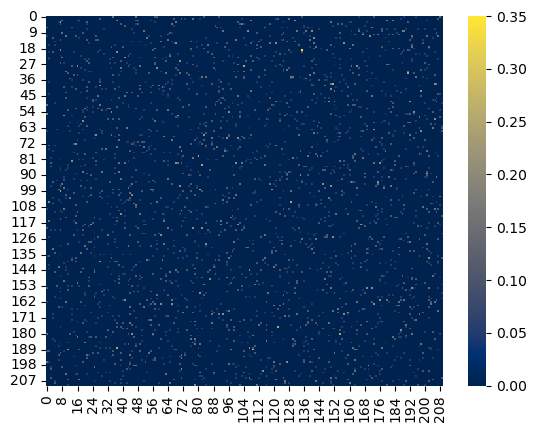

In [24]:
heatmap(W_hasp_band.todense(), cmap=color_palette("cividis", as_cmap=True))

### Univariate matrices

In [25]:
# HADSP + uni
Win_hadsp_uni, W_hadsp_uni, bias_hadsp_uni, connectivity_hadsp_uni, sr_hadsp_uni = initialise_and_train(input_scaling, n, bias_scaling, SEED, X_pretrain.flatten())

# random + uni
Win_normal, W_normal, bias_normal =  init_matrices(n, 1, connectivity_hadsp_uni)
bias_normal= bias_normal*bias_scaling
Win_normal= Win_normal*input_scaling   

eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_normal = max(abs(eigen_normal))


100%|█████████████████████████████████████████████████████████████████| 13580/13580 [00:04<00:00, 3164.27it/s]


<Axes: >

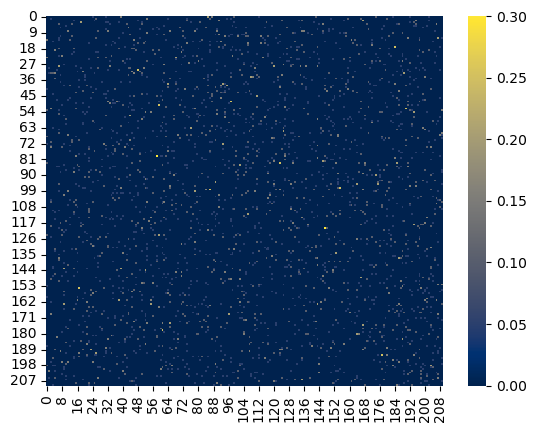

In [26]:
heatmap(W_hadsp_uni.todense(), cmap=color_palette("cividis", as_cmap=True))

## Spectral radius normalisation

In [27]:
print(sr_normal)
print(sr_hadsp_uni)
print(sr_3)
print(sr_adsp)

1.0000000023012958
0.9261097874526294
0.9918843245967857
0.991884324823667


In [28]:
# Spectral radius normalisation
normal_sr = 1.2
W_normal = W_normal/sr_normal*normal_sr
W_hadsp_uni = W_hadsp_uni/sr_hadsp_uni*normal_sr
W_3 = W_3/sr_3*normal_sr
W_hasp_band = W_hasp_band/sr_adsp*normal_sr

# Performance

In [29]:
from reservoirpy.nodes import Reservoir, Ridge, Input, ESN
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score

N_JOBS = -1

def train_and_predict_model(W, Win, bias, activation_function, ridge_coef, compute_data, predict_data):
    # To remember : 
    #  For reservoirpy   pre_s = W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias
    
    reservoir = Reservoir(units=n, 
                          W =csr_matrix(W), 
                          Win=csr_matrix(np.diag(Win.toarray().flatten())), 
                          bias=csr_matrix(bias).T, 
                          activation=activation_function,
                          equation='external'
                         )
    readout = Ridge(ridge=ridge_coef)
    model = ESN(reservoir=reservoir, readout=readout)
    
    states_train = []

    def compute_state(x):
        return reservoir.run(x, reset=True)[-1, np.newaxis].flatten()
    
    states_train = Parallel(n_jobs=N_JOBS)(delayed(compute_state)(x) for x in compute_data)

    readout.fit(np.array(states_train), Y_train)

    Y_pred = []
    def predict(x):
        states = reservoir.run(x, reset=True)
        y = readout.run(states[-1, np.newaxis])
        return y

    Y_pred = Parallel(n_jobs=N_JOBS)(delayed(predict)(x) for x in predict_data)

    return Y_pred


def compute_score(Y_pred, Y_test, model_name):
    Y_pred_class = [np.argmax(y_p) for y_p in Y_pred]
    Y_test_class = [np.argmax(y_t) for y_t in Y_test]

    score = accuracy_score(Y_test_class, Y_pred_class)

    print(f"Accuracy for {model_name}: {score * 100:.3f} %")
    return score
    

## Classification for multivariate

In [30]:
# We want the size of the reservoir to be at least 200
caca = []
caca_test = []
for i in tqdm(range(len(X_train_band))):
    #caca.append(np.repeat(X_train[i], K, axis=1))
    caca.append(np.repeat(X_train_band[i], K, axis=0).T) # axis still depend of X_train shape
    
for i in tqdm(range(len(X_test_band))):
    #caca_test.append(np.repeat(X_test[i], K, axis=1))
    caca_test.append(np.repeat(X_test_band[i], K, axis=0).T)

100%|███████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1273.55it/s]


In [31]:

ridge_coef = 1e-6

# To remember : 
#  For reservoirpy   pre_s = W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias
Y_pred_hasp_band = train_and_predict_model(W_hasp_band, Win_hasp_band, bias_hasp_band, activation_function, ridge_coef, caca, caca_test)

Y_pred_3 = train_and_predict_model(W_3, Win_3, bias_3, activation_function, ridge_coef, caca, caca_test)


Running Reservoir-0: 100%|██████████| 2430/2430 [00:00<00:00, 14852.94it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 29330.80it/s]05.13it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 13888.42it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 28532.68it/s]

Running Reservoir-0:  46%|████▌     | 1483/3226 [00:00<00:00, 14815.46it/s]/Users/tanguy/miniforge3/envs/hadsp_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running Reservoir-0: 100%|██████████| 3327/3327 [00:00<00:00, 9088.73it/s]]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Running Reservoir-0: 100%|██████████| 2697/2697 [00:00<00:00, 13974.59it/s] 

Running Ridge-0: 

In [32]:
score = compute_score(Y_pred_hasp_band, Y_test, "HADSP multi")

score = compute_score(Y_pred_3, Y_test, "random multi")

Accuracy for HADSP multi: 15.800 %
Accuracy for random multi: 17.200 %


## Classification for univariate

In [33]:
# Create a list to store the arrays

pipi = []
pipi_test = []

for i in range(len(X_train)):
    pipi.append(np.repeat(X_train[i], n, axis=1))
    #pipi.append(np.repeat(X_train[i], n, axis=0).T) # axis still depend of X_train shape
    
for i in range(len(X_test)):
    pipi_test.append(np.repeat(X_test[i], n, axis=1))
    #pipi_test.append(np.repeat(X_test[i], n, axis=0).T)
    
pipi[0].shape

(2859, 210)

In [34]:
Y_pred_hadsp_uni = train_and_predict_model(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, activation_function, ridge_coef, pipi, pipi_test)

Y_pred_normal = train_and_predict_model(W_normal, Win_normal, bias_normal, activation_function, ridge_coef, pipi, pipi_test)

Running Reservoir-2: 100%|██████████| 3921/3921 [00:00<00:00, 18928.58it/s]

Running Reservoir-2:  25%|██▍       | 1288/5208 [00:00<00:00, 12876.02it/s]/Users/tanguy/miniforge3/envs/hadsp_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running Reservoir-2: 100%|██████████| 3626/3626 [00:00<00:00, 17971.76it/s]

Running Ridge-2: 100%|██████████| 1/1 [00:00<00:00, 30393.51it/s]

Running Ridge-3: 100%|██████████| 1/1 [00:00<00:00, 29330.80it/s]94.87it/s]

Running Reservoir-3: 100%|██████████| 3821/3821 [00:00<00:00, 21584.77it/s]

Running Ridge-3: 100%|██████████| 1/1 [00:00<00:00, 29537.35it/s]


In [35]:
score = compute_score(Y_pred_hadsp_uni, Y_test, "HADSP uni")

score = compute_score(Y_pred_normal, Y_test, "random uni")

Accuracy for HADSP uni: 7.933 %
Accuracy for random uni: 8.000 %
